In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
# Basic libraries
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [27]:
action_names = [
    'Swipe left','Swipe right','Wave','Clap','Throw','Arm cross','Basketball shoot',
    'Basketball dribble','Bowling','Boxing','Baseball swing','Tennis swing','Arm curl',
    'Tennis serve','Push','Knock','Catch','Pick up & throw','Jogging','Walking',
    'Sit to stand','Stand to sit','Lunge','Squat','Kicking','Jumping jack','Jump forward'
]

# Path where depth files are stored
depth_path = "/kaggle/input/utd-mhad-depth/Depth"

In [28]:
def average_frame(D):
    """
    Compute the average frame across the depth sequence (for visualization).
    D is a 3D numpy array: (height, width, num_frames).
    """
    return np.mean(D, axis=2)

def normalize_stack(stack):
    """
    Normalize depth stack to [0,1].
    """
    stack = stack.astype(np.float32)
    stack -= stack.min()
    stack /= stack.max() + 1e-8
    return stack


In [29]:
# Initialize storage
X_data = []   # depth samples
y_data = []   # action labels

# Parameters
num_actions = len(action_names)
num_subjects = 8
num_trials = 4

for aID in range(1, num_actions+1):  # Actions
    for sID in range(1, num_subjects+1):  # Subjects
        for tID in range(1, num_trials+1):  # Trials
            filename = f"a{aID}_s{sID}_t{tID}_depth.mat"
            fpath = os.path.join(depth_path, filename)
            
            if os.path.exists(fpath):
                # Load depth .mat file
                mat = scipy.io.loadmat(fpath)
                D = mat['d_depth']  # depth data
                
                # Convert to numpy stack
                D = np.array(D)
                
                # Normalize
                Dnorm = normalize_stack(D)
                
                # Resize to fixed size (e.g., 60x60 for CNN)
                # Take average frame representation
                frame = average_frame(Dnorm)
                frame_resized = tf.image.resize(frame[...,None], (60,60)).numpy()
                
                # Store
                X_data.append(frame_resized)
                y_data.append(aID-1)   # zero-based label


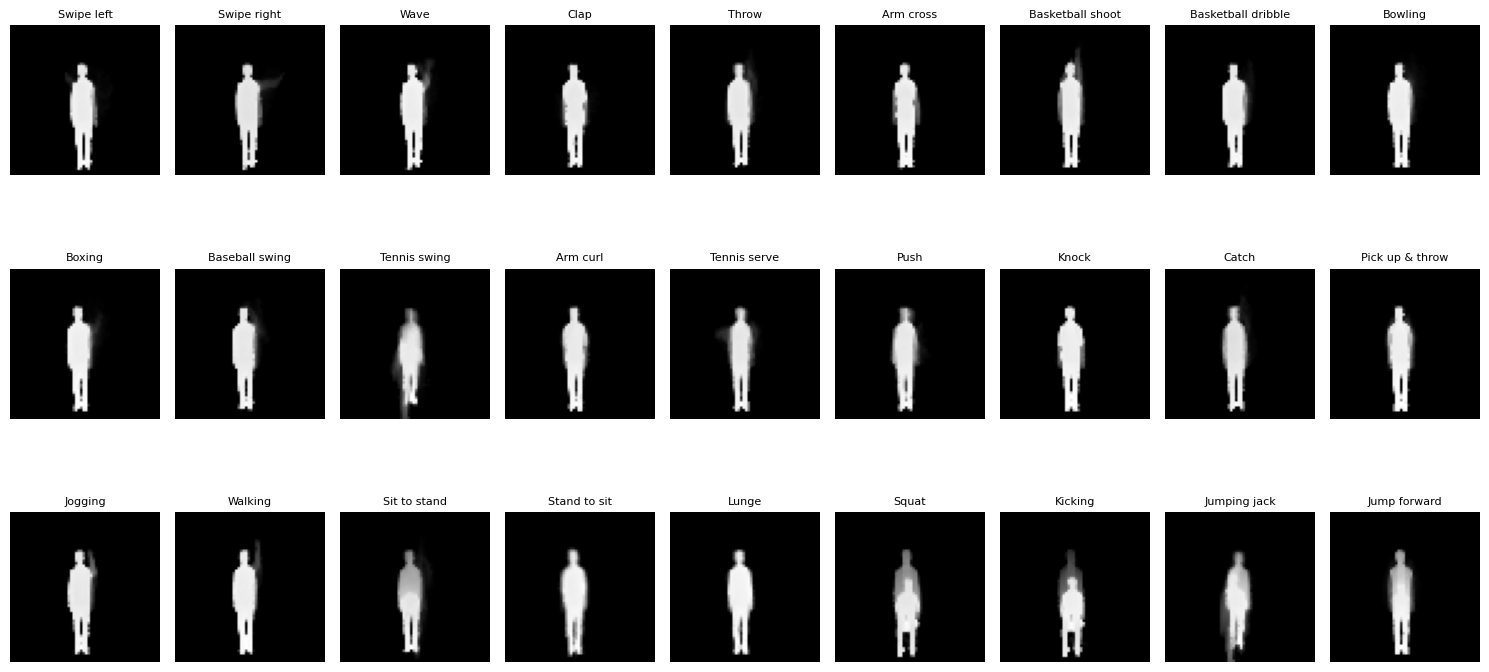

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Find unique actions actually present in y_data
unique_actions = np.unique(y_data)

plt.figure(figsize=(15, 8))
for i, a in enumerate(unique_actions):
    # pick the first sample index for this action
    idx = np.where(y_data == a)[0][0]
    
    plt.subplot(3, 9, i+1)   # adjust if actions > 27
    plt.imshow(X_data[idx].squeeze(), cmap="gray")
    plt.title(action_names[a], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [31]:
# Convert to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# Ensure shape is (samples, height, width, channels)
print("Data shape:", X_data.shape)
print("Labels shape:", y_data.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# One-hot encoding labels
num_classes = len(action_names)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


Data shape: (861, 60, 60, 1)
Labels shape: (861,)


In [32]:
from tensorflow.keras import Input

def build_depth_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),                      
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

depth_model = build_depth_model(X_train.shape[1:], num_classes)
depth_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,406,875 (5.37 MB)

 Trainable params: 1,406,875 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = depth_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    verbose=1
)


Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.0373 - loss: 3.3017 - val_accuracy: 0.0507 - val_loss: 3.2940
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.0530 - loss: 3.2882 - val_accuracy: 0.0797 - val_loss: 3.2888
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1019 - loss: 3.2623 - val_accuracy: 0.1014 - val_loss: 3.2648
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1024 - loss: 3.2177 - val_accuracy: 0.1014 - val_loss: 3.1921
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1283 - loss: 3.1139 - val_accuracy: 0.1594 - val_loss: 3.0849
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.1375 - loss: 2.9771 - val_accuracy: 0.1667 - val_loss: 2.9130
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.1952 - loss: 2.7546 - val_accuracy: 0.1812 - val_loss: 2.7931
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2287 - loss: 2.5963 - val_accuracy: 0.2101 - v

In [34]:
# Evaluate on test set
test_loss, test_acc = depth_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.5087


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


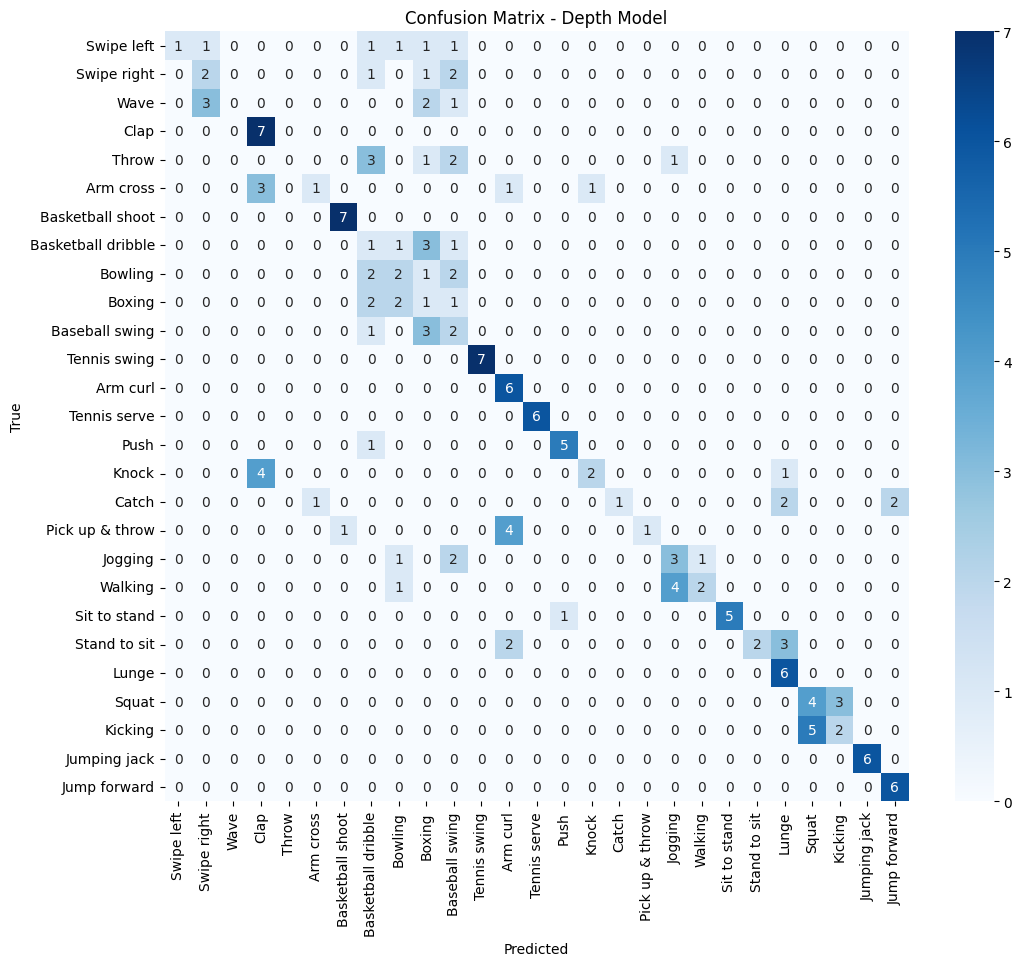

In [35]:
# Predictions
y_pred = depth_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=action_names, yticklabels=action_names,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Depth Model")
plt.show()


In [36]:
# temporal depth
import os
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

def pad_or_trim_frames(video, target_frames=20):
    """
    Ensure each depth video has exactly `target_frames` frames.
    - If too many: uniformly sample.
    - If too few: pad with last frame.
    """
    num_frames = video.shape[2]
    if num_frames > target_frames:
        idx = np.linspace(0, num_frames-1, target_frames).astype(int)
        return video[:, :, idx]
    elif num_frames < target_frames:
        pad = target_frames - num_frames
        pad_frames = np.repeat(video[:, :, -1][:,:,None], pad, axis=2)
        return np.concatenate([video, pad_frames], axis=2)
    else:
        return video

In [37]:
# temporal depth
# Storage
X_data, y_data = [], []

num_actions = len(action_names)
num_subjects = 8
num_trials = 4

target_h, target_w, target_frames = 60, 60, 20   # fixed size

for aID in range(1, num_actions+1):
    for sID in range(1, num_subjects+1):
        for tID in range(1, num_trials+1):
            fname = f"a{aID}_s{sID}_t{tID}_depth.mat"
            fpath = os.path.join(depth_path, fname)

            if os.path.exists(fpath):
                mat = scipy.io.loadmat(fpath)
                D = np.array(mat['d_depth'])   # H×W×T

                # Normalize
                D = normalize_stack(D)

                # Pad or trim temporal dimension
                D = pad_or_trim_frames(D, target_frames)

                # Resize spatially
                frames_resized = []
                for i in range(D.shape[2]):
                    frame = tf.image.resize(D[:,:,i][...,None], (target_h, target_w)).numpy()
                    frames_resized.append(frame[:,:,0])
                video = np.stack(frames_resized, axis=2)  # H×W×T

                # Add channel dimension → H×W×T×1
                video = video[..., None]

                X_data.append(video)
                y_data.append(aID-1)


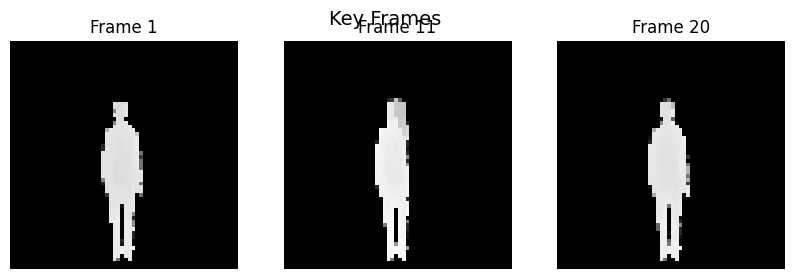

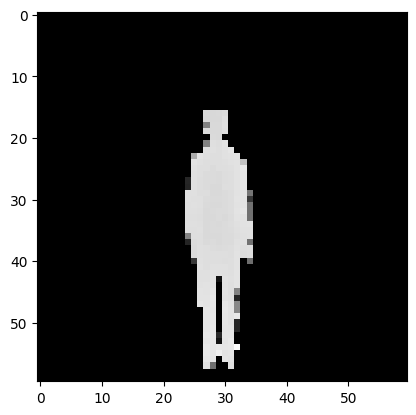

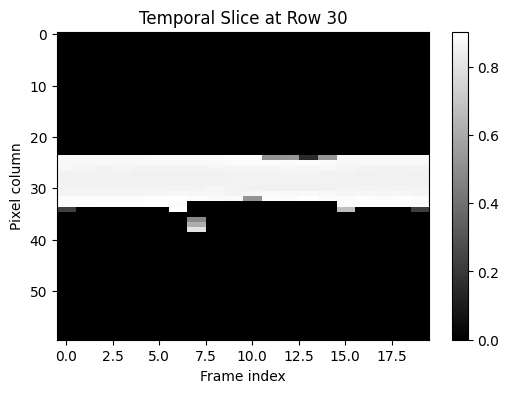

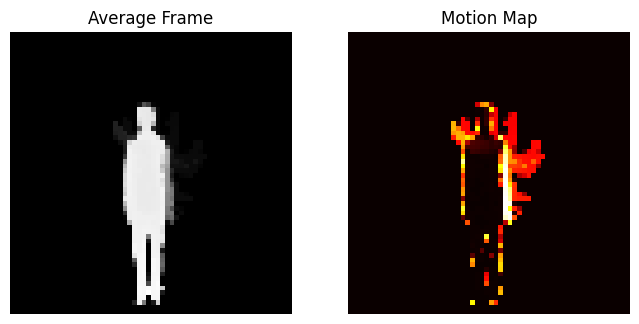

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [38]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def visualize_depth_video(video, row=30):
    """
    Visualizes one depth video (shape: H×W×T×1).
    Shows: key frames, animation, temporal slice, motion map.
    """
    frames = video.squeeze()  # (H,W,T)
    H, W, T = frames.shape
    
    # --- 1. Key Frames (1st, middle, last) ---
    indices = [0, T//2, T-1]
    plt.figure(figsize=(10,3))
    for i, idx in enumerate(indices):
        plt.subplot(1,3,i+1)
        plt.imshow(frames[:,:,idx], cmap='gray')
        plt.title(f"Frame {idx+1}")
        plt.axis("off")
    plt.suptitle("Key Frames", fontsize=14)
    plt.show()
    
    # --- 2. Video Animation ---
    fig, ax = plt.subplots()
    im = ax.imshow(frames[:,:,0], cmap='gray', vmin=0, vmax=1)
    def update(i):
        im.set_array(frames[:,:,i])
        ax.set_title(f"Frame {i+1}/{T}")
    ani = animation.FuncAnimation(fig, update, frames=T, interval=300)
    plt.show()
    
    # --- 3. Temporal Slice (pick one row across time) ---
    slice_img = frames[row,:,:]  # (W, T)
    plt.figure(figsize=(6,4))
    plt.imshow(slice_img, cmap="gray", aspect="auto")
    plt.title(f"Temporal Slice at Row {row}")
    plt.xlabel("Frame index")
    plt.ylabel("Pixel column")
    plt.colorbar()
    plt.show()
    
    # --- 4. Average Frame & Motion Map ---
    avg = np.mean(frames, axis=2)
    motion = np.std(frames, axis=2)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(avg, cmap='gray')
    plt.title("Average Frame")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(motion, cmap='hot')
    plt.title("Motion Map")
    plt.axis("off")
    plt.show()

# Example: visualize the first video sample
visualize_depth_video(X_data[0])


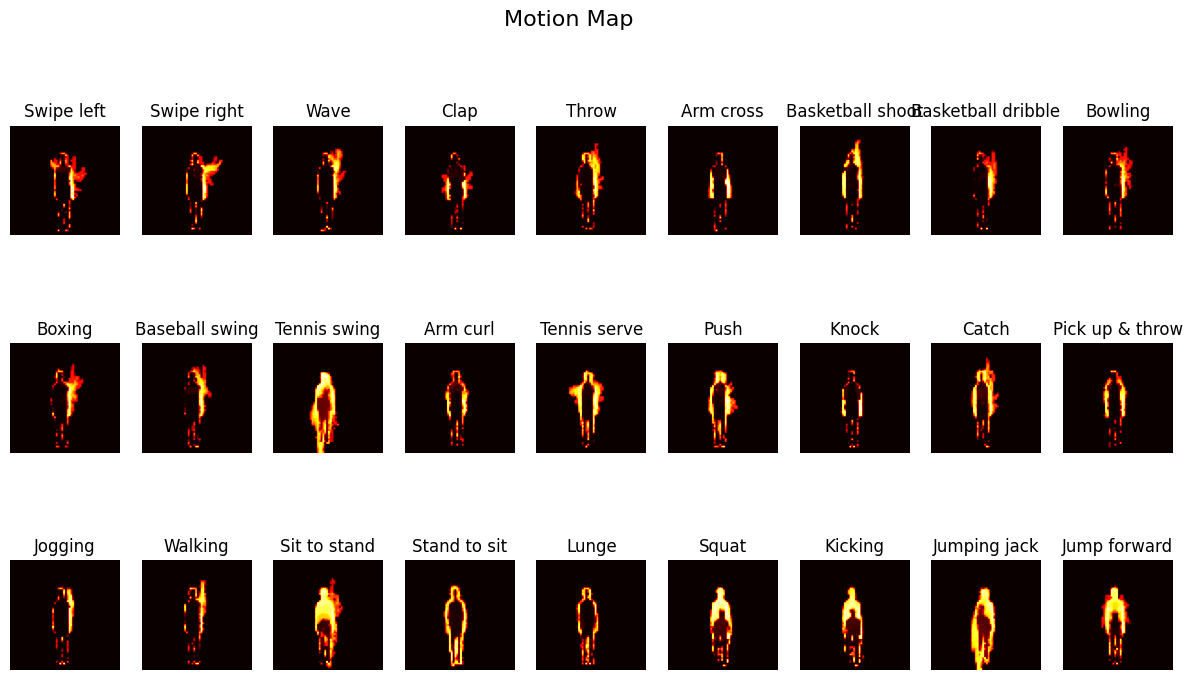

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def show_motion_map_per_action(X_data, y_data, action_names):
    """
    Shows one motion map (std across time) for each action class.
    """
    y_data = np.array(y_data)   # ensure it's a numpy array
    num_actions = len(action_names)

    plt.figure(figsize=(15,8))

    for a in range(num_actions):
        # find first sample index with this action
        idxs = np.where(y_data == a)[0]
        if len(idxs) == 0:
            continue
        idx = idxs[0]

        video = X_data[idx].squeeze()   # (H,W,T)
        motion = np.std(video, axis=2)  # motion intensity

        plt.subplot(3,9,a+1)
        plt.imshow(motion, cmap='hot')
        plt.title(action_names[a])
        plt.axis("off")

    plt.suptitle("Motion Map ", fontsize=16)
    plt.show()

# import matplotlib.pyplot as plt
# import numpy as np

# # Find unique actions actually present in y_data
# unique_actions = np.unique(y_data)

# plt.figure(figsize=(15, 8))
# for i, a in enumerate(unique_actions):
#     # pick the first sample index for this action
#     idx = np.where(y_data == a)[0][0]
    
#     plt.subplot(3, 9, i+1)   # adjust if actions > 27
#     plt.imshow(X_data[idx].squeeze(), cmap="gray")
#     plt.title(action_names[a], fontsize=8)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()
show_motion_map_per_action(X_data, y_data, action_names)

In [40]:
X_data = np.array(X_data)
y_data = np.array(y_data)

print("Depth data shape:", X_data.shape)  
# Expected: (num_samples, 60, 60, 20, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

num_classes = len(action_names)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Depth data shape: (861, 60, 60, 20, 1)


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout, Input
# def build_depth_model(input_shape, num_classes):
#     model = Sequential([
#         Conv3D(32, (3,3,3), activation='relu', input_shape=input_shape),
#         MaxPooling3D((2,2,2)),

#         Conv3D(64, (3,3,3), activation='relu'),
#         MaxPooling3D((2,2,2)),

#         Flatten(),
#         Dense(256, activation='relu'),
#         Dropout(0.5),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model





# big_depth_model = build_big_depth_model(X_train.shape[1:], num_classes)
# big_depth_model.summary()

def build_depth_model_2M(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv3D(32, (3,3,3), activation='relu', padding="same"),
        MaxPooling3D((2,2,2)),

        Conv3D(64, (3,3,3), activation='relu', padding="same"),
        MaxPooling3D((2,2,2)),


        Flatten(),   # (None, ~7168 features)

        Dense(256, activation='relu'),  # ~1.8M params
        Dropout(0.5),


        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

depth_model = build_depth_model_2M(X_train.shape[1:], num_classes)
depth_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 60, 60, 20, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 30, 30, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 30, 30, 10, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 15, 15, 5, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 72000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    18,432,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,495,451 (70.55 MB)

 Trainable params: 18,495,451 (70.55 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = depth_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    verbose=1
)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.0547 - loss: 3.3710 - val_accuracy: 0.2826 - val_loss: 2.9525
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.2949 - loss: 2.4856 - val_accuracy: 0.6304 - val_loss: 1.3251
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.6878 - loss: 1.0713 - val_accuracy: 0.7899 - val_loss: 0.8466
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.8056 - loss: 0.7088 - val_accuracy: 0.7826 - val_loss: 0.7059
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8431 - loss: 0.5049 - val_accuracy: 0.7971 - val_loss: 0.5617
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.8868 - loss: 0.3134 - val_accuracy: 0.8696 - val_loss: 0.4741
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9167 - loss: 0.2447 - val_accuracy: 0.8913 - val_loss: 0.4180
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.9474 - loss: 0.1721 - val_accuracy: 0.8551 - v

Test Accuracy: 0.9249
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


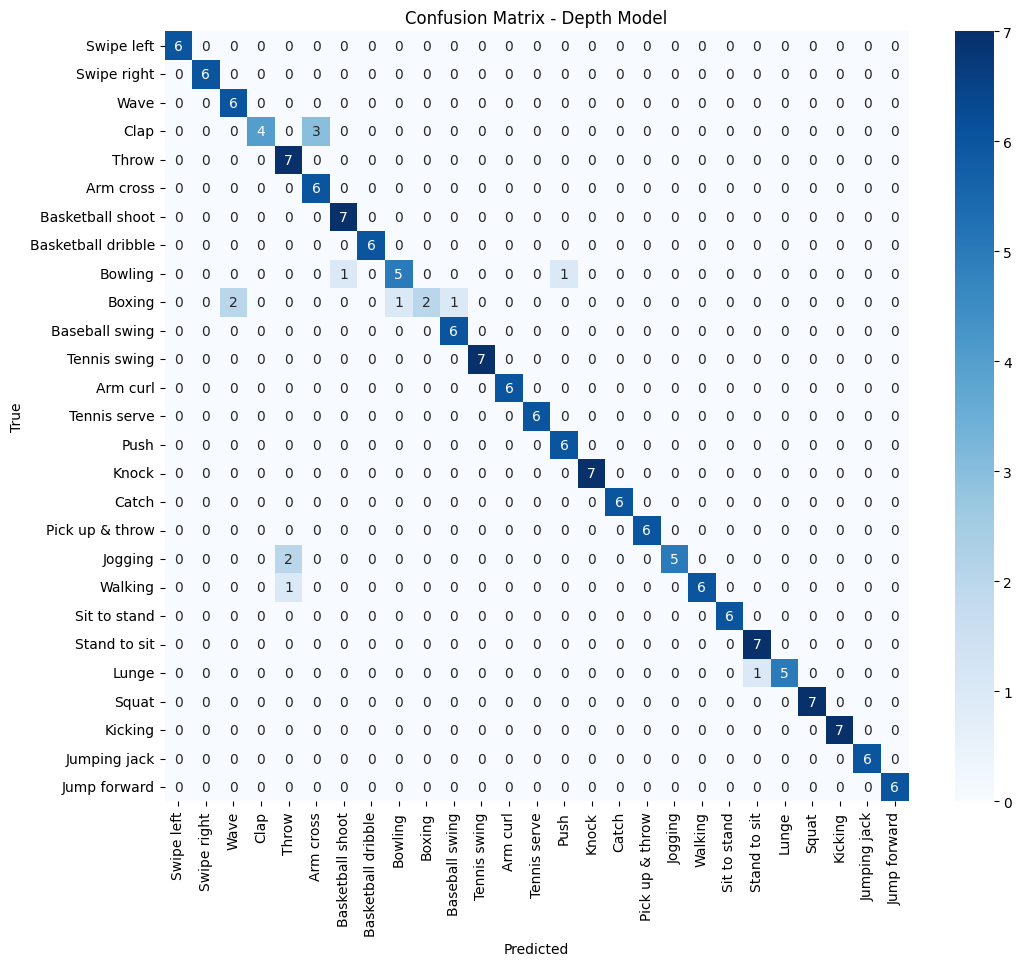

In [43]:
# Evaluate on test set
test_loss, test_acc = depth_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
# Predictions
y_pred = depth_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=action_names, yticklabels=action_names,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Depth Model")
plt.show()
